In [1]:
import gdown
! pip install git+https://github.com/yoyololicon/spectrogram-inversion
!mkdir download

In [3]:
url = 'https://drive.google.com/file/d/1YmlfQc5VCAFa-sRI4D3IHBSgefXG4MyQ/view?usp=drive_link'
gdown.download(url=url, output='/content/download/', fuzzy=True)


Downloading...
From (original): https://drive.google.com/uc?id=1YmlfQc5VCAFa-sRI4D3IHBSgefXG4MyQ
From (redirected): https://drive.google.com/uc?id=1YmlfQc5VCAFa-sRI4D3IHBSgefXG4MyQ&confirm=t&uuid=d77d6bf5-e9b2-4483-8224-3050c0c95a46
To: /content/download/subset_raw.zip
100%|██████████| 1.37G/1.37G [00:17<00:00, 79.7MB/s]


'/content/download/subset_raw.zip'

In [4]:
!mv download/subset_raw.zip .
!unzip subset_raw.zip

In [2]:
# @title PSGD optimizes variational models quite well
"""
Created in May, 2018
Pytorch functions for preconditioned SGD
@author: XILIN LI, lixilinx@gmail.com

Updated in Dec, 2020:
Wrapped Kronecker product preconditioner for easy use: the code will select the proper Kronecker product
preconditioner based on the formats of input left and right preconditioners.
Added torch.jit.script decorator by default.

Updates in 2022:
Added low-rank approximation (LRA) and XMat preconditioners.
Wrapped LRA, XMat and Newton preconditioners as classes for easy use.

Updates in 2023:
Added gradient whitening preconditioner.
Replaced matrix norm lower bound max(abs(A)) with sqrt(max(max_i sum_j a_ij^2, max_j sum_i a_ij^2)).
Initialize Q to ((v^T*v)/(h^T*h))^(1/4)*I if the initial scale of Q is set to None.
Wrapped affine family as a class.

Updates in 2024 Jan:
Further tightened lower bound of a matrix spectral norm (see norm_lower_bound).

Updates in 2024 Mar:
By default, the 2nd (previously 1st) order derivative info is used to normalized the step size for preconditioner update.
For class Newton optimizer, also providing a choice for keeping inv(Q) via matrix inverse rank-2 update.
Update rule for a triangular Q is modified to approximately match that on GL(n, R).
Functional usage of PSGD is to be deprecated, and not updated.
"""

import torch


def norm_lower_bound(A):
    """
    Returns a cheap lower bound for the spectral norm of A.
    Numerical results on random matrices with a wide range of distributions and sizes suggest,
        norm(A) <= sqrt(2) * norm_lower_bound(A)
    Looks to be a very tight lower bound.
    """
    aa = torch.real(A * A.conj())
    value0, i = torch.max(torch.sum(aa, dim=0), 0)
    value1, j = torch.max(torch.sum(aa, dim=1), 0)
    if value0 > value1:
        x = A[:, i].conj() @ A
        # We must have norm(x) > 0 since norm(x) >= value0 > value1 >= 0
        # Also, avoid expression norm(x*A^H)/norm(x) as x*A^H could under/over flow
        return torch.linalg.vector_norm((x / torch.linalg.vector_norm(x)) @ A.H)
    else:
        x = A @ A[j].conj()
        normx = torch.linalg.vector_norm(x)
        if normx > 0:
            # Again, avoid expression norm(A^H*x)/norm(x) as A^H*x could under/over flow
            return torch.linalg.vector_norm(A.H @ (x / normx))
        else:  # A = 0
            return normx


def woodbury_identity_(invA, U, V):
    # implements the Woodbury identity,
    #
    #   inv(A + U*V) = inv(A) - inv(A)*U*inv(I + V*inv(A)*U)*V*inv(A)
    #
    # with inplace update of invA.
    #
    # Note that using the Woodbury identity multiple times could accumulate numerical erros.
    invAU = invA @ U
    VinvAU = V @ invAU
    I = torch.eye(VinvAU.shape[0], dtype=VinvAU.dtype, device=VinvAU.device)
    invA.sub_( invAU @ torch.linalg.solve(I + VinvAU, V@invA) )


def triu01(A):
    # it is useful as for a small A, the R of QR decomposition qr(I + A) is about I + triu(A, 0) + triu(A, 1)
    return torch.triu(A, diagonal=0) + torch.triu(A, diagonal=1)


###############################################################################
@torch.jit.script
def update_precond_dense(Q, dxs, dgs, step=0.01, _tiny=1.2e-38):
    # type: (Tensor, List[Tensor], List[Tensor], float, float) -> Tensor
    """
    update dense preconditioner P = Q^T*Q
    Q: Cholesky factor of preconditioner with positive diagonal entries
    dxs: list of perturbations of parameters
    dgs: list of perturbations of gradients
    step: update step size normalized to range [0, 1]
    _tiny: an offset to avoid division by zero
    """
    dx = torch.cat([torch.reshape(x, [-1, 1]) for x in dxs])
    dg = torch.cat([torch.reshape(g, [-1, 1]) for g in dgs])

    a = Q.mm(dg)
    #b = torch.triangular_solve(dx, Q, upper=True, transpose=True)[0]
    b = torch.linalg.solve_triangular(Q.t(), dx, upper=False)

    grad = torch.triu(a.mm(a.t()) - b.mm(b.t()))
    # step0 = step/(grad.abs().max() + _tiny)
    step0 = step/(norm_lower_bound(grad) + _tiny)

    return Q - step0*grad.mm(Q)

@torch.jit.script
def precond_grad_dense(Q, grads):
    # type: (Tensor, List[Tensor]) -> List[Tensor]
    """
    return preconditioned gradient using dense preconditioner
    Q: Cholesky factor of preconditioner
    grads: list of gradients
    """
    grad = [torch.reshape(g, [-1, 1]) for g in grads]
    lens = [g.shape[0] for g in grad]
    grad = torch.cat(grad)
    grad = Q.t().mm(Q.mm(grad))

    pre_grads = []
    idx = 0
    for i in range(len(grads)):
        pre_grads.append(torch.reshape(grad[idx : idx + lens[i]], grads[i].shape))
        idx = idx + lens[i]

    return pre_grads


###############################################################################
def update_precond_kron(Ql, Qr, dX, dG, step=0.01, _tiny=1.2e-38):
    """
    Update Kronecker product preconditioner P = kron_prod(Qr^T*Qr, Ql^T*Ql)
    Either Ql or Qr can be sparse, and the code can choose the right update rule.
    dX: perturbation of (matrix) parameter
    dG: perturbation of (matrix) gradient
    step: update step size
    _tiny: an offset to avoid division by zero
    """
    m, n = Ql.shape
    p, q = Qr.shape
    if m==n: # left is dense
        if p==q: #(dense, dense) format
            return _update_precond_dense_dense(Ql, Qr, dX, dG, step, _tiny)
        elif p==2: # (dense, normalization) format
            return _update_precond_norm_dense(Qr, Ql, dX.t(), dG.t(), step, _tiny)[::-1]
        elif p==1: # (dense, scaling) format
            return _update_precond_dense_scale(Ql, Qr, dX, dG, step, _tiny)
        else:
            raise Exception('Unknown Kronecker product preconditioner')
    elif m==2: # left is normalization
        if p==q: # (normalization, dense) format
            return _update_precond_norm_dense(Ql, Qr, dX, dG, step, _tiny)
        elif p==1: # (normalization, scaling) format
            return _update_precond_norm_scale(Ql, Qr, dX, dG, step, _tiny)
        else:
            raise Exception('Unknown Kronecker product preconditioner')
    elif m==1: # left is scaling
        if p==q: # (scaling, dense) format
            return _update_precond_dense_scale(Qr, Ql, dX.t(), dG.t(), step, _tiny)[::-1]
        elif p==2: # (scaling, normalization) format
            return _update_precond_norm_scale(Qr, Ql, dX.t(), dG.t(), step, _tiny)[::-1]
        else:
            raise Exception('Unknown Kronecker product preconditioner')
    else:
        raise Exception('Unknown Kronecker product preconditioner')


def precond_grad_kron(Ql, Qr, Grad):
    """
    return preconditioned gradient using Kronecker product preconditioner P = kron_prod(Qr^T*Qr, Ql^T*Ql)
    Either Ql or Qr can be sparse, and the code can choose the right way to precondition the gradient
    Grad: (matrix) gradient
    """
    m, n = Ql.shape
    p, q = Qr.shape
    if m==n: # left is dense
        if p==q: #(dense, dense) format
            return _precond_grad_dense_dense(Ql, Qr, Grad)
        elif p==2: # (dense, normalization) format
            return _precond_grad_norm_dense(Qr, Ql, Grad.t()).t()
        elif p==1: # (dense, scaling) format
            return _precond_grad_dense_scale(Ql, Qr, Grad)
        else:
            raise Exception('Unknown Kronecker product preconditioner')
    elif m==2: # left is normalization
        if p==q: # (normalization, dense) format
            return _precond_grad_norm_dense(Ql, Qr, Grad)
        elif p==1: # (normalization, scaling) format
            return _precond_grad_norm_scale(Ql, Qr, Grad)
        else:
            raise Exception('Unknown Kronecker product preconditioner')
    elif m==1: # left is scaling
        if p==q: # (scaling, dense) format
            return _precond_grad_dense_scale(Qr, Ql, Grad.t()).t()
        elif p==2: # (scaling, normalization) format
            return _precond_grad_norm_scale(Qr, Ql, Grad.t()).t()
        else:
            raise Exception('Unknown Kronecker product preconditioner')
    else:
        raise Exception('Unknown Kronecker product preconditioner')


###############################################################################
@torch.jit.script
def _update_precond_dense_dense(Ql, Qr, dX, dG, step=0.01, _tiny=1.2e-38):
    # type: (Tensor, Tensor, Tensor, Tensor, float, float) -> Tuple[Tensor, Tensor]
    """
    update Kronecker product preconditioner P = kron_prod(Qr^T*Qr, Ql^T*Ql)
    Ql: (left side) Cholesky factor of preconditioner with positive diagonal entries
    Qr: (right side) Cholesky factor of preconditioner with positive diagonal entries
    dX: perturbation of (matrix) parameter
    dG: perturbation of (matrix) gradient
    step: update step size normalized to range [0, 1]
    _tiny: an offset to avoid division by zero
    """
    max_l = torch.max(torch.diag(Ql))
    max_r = torch.max(torch.diag(Qr))

    rho = torch.sqrt(max_l/max_r)
    Ql /= rho
    Qr *= rho

    #A = Ql.mm( dG.mm( Qr.t() ) )
    #Bt = torch.triangular_solve((torch.triangular_solve(dX.t(), Qr, upper=True, transpose=True))[0].t(),
    #                 Ql, upper=True, transpose=True)[0]
    A = torch.linalg.multi_dot([Ql, dG, Qr.t()])
    Bt = torch.linalg.solve_triangular(Ql.t(), torch.linalg.solve_triangular(Qr, dX, upper=True, left=False), upper=False)

    grad1 = torch.triu(A.mm(A.t()) - Bt.mm(Bt.t()))
    grad2 = torch.triu(A.t().mm(A) - Bt.t().mm(Bt))

    # step1 = step/(torch.max(torch.abs(grad1)) + _tiny)
    # step2 = step/(torch.max(torch.abs(grad2)) + _tiny)
    step1 = step/(norm_lower_bound(grad1) + _tiny)
    step2 = step/(norm_lower_bound(grad2) + _tiny)

    return Ql - step1*grad1.mm(Ql), Qr - step2*grad2.mm(Qr)

@torch.jit.script
def _precond_grad_dense_dense(Ql, Qr, Grad):
    # type: (Tensor, Tensor, Tensor) -> Tensor
    """
    return preconditioned gradient using Kronecker product preconditioner
    Ql: (left side) Cholesky factor of preconditioner
    Qr: (right side) Cholesky factor of preconditioner
    Grad: (matrix) gradient
    """
    #return torch.chain_matmul(Ql.t(), Ql, Grad, Qr.t(), Qr)
    return torch.linalg.multi_dot([Ql.t(), Ql, Grad, Qr.t(), Qr])


###############################################################################
# (normalization, dense) format Kronecker product preconditioner
@torch.jit.script
def _update_precond_norm_dense(ql, Qr, dX, dG, step=0.01, _tiny=1.2e-38):
    # type: (Tensor, Tensor, Tensor, Tensor, float, float) -> Tuple[Tensor, Tensor]
    """
    update (normalization, dense) Kronecker product preconditioner P = kron_prod(Qr^T*Qr, Ql^T*Ql), where
    dX and dG have shape (M, N)
    ql has shape (2, M)
    Qr has shape (N, N)
    ql[0] is the diagonal part of Ql
    ql[1,0:-1] is the last column of Ql, excluding the last entry
    dX is perturbation of (matrix) parameter
    dG is perturbation of (matrix) gradient
    step: update step size normalized to range [0, 1]
    _tiny: an offset to avoid division by zero
    """
    # make sure that Ql and Qr have similar dynamic range
    max_l = torch.max(ql[0])
    max_r = torch.max(torch.diag(Qr))
    rho = torch.sqrt(max_l/max_r)
    ql /= rho
    Qr *= rho

    # refer to https://arxiv.org/abs/1512.04202 for details
    A = ql[0:1].t()*dG + ql[1:].t().mm( dG[-1:] ) # Ql*dG
    A = A.mm(Qr.t())

    Bt = dX/ql[0:1].t()
    Bt[-1:] -= (ql[1:]/(ql[0:1]*ql[0,-1])).mm(dX)
    #Bt = torch.triangular_solve(Bt.t(), Qr, upper=True, transpose=True)[0].t()
    Bt = torch.linalg.solve_triangular(Qr, Bt, upper=True, left=False)

    grad1_diag = torch.sum(A*A, dim=1) - torch.sum(Bt*Bt, dim=1)
    grad1_bias = A[:-1].mm(A[-1:].t()) - Bt[:-1].mm(Bt[-1:].t())
    grad1_bias = torch.cat([torch.squeeze(grad1_bias), grad1_bias.new_zeros(1)])

    step1 = step/(torch.max(torch.max(torch.abs(grad1_diag)),
                            torch.max(torch.abs(grad1_bias))) + _tiny)
    new_ql0 = ql[0] - step1*grad1_diag*ql[0]
    new_ql1 = ql[1] - step1*(grad1_diag*ql[1] + ql[0,-1]*grad1_bias)

    grad2 = torch.triu(A.t().mm(A) - Bt.t().mm(Bt))
    # step2 = step/(torch.max(torch.abs(grad2)) + _tiny)
    step2 = step/(norm_lower_bound(grad2) + _tiny)

    return torch.stack((new_ql0, new_ql1)), Qr - step2*grad2.mm(Qr)

@torch.jit.script
def _precond_grad_norm_dense(ql, Qr, Grad):
    # type: (Tensor, Tensor, Tensor) -> Tensor
    """
    return preconditioned gradient using (normalization, dense) Kronecker product preconditioner
    Suppose Grad has shape (M, N)
    ql[0] is the diagonal part of Ql
    ql[1, 0:-1] is the last column of Ql, excluding the last entry
    Qr: shape (N, N), Cholesky factor of right preconditioner
    Grad: (matrix) gradient
    """
    preG = ql[0:1].t()*Grad + ql[1:].t().mm(Grad[-1:]) # Ql*Grad
    #preG = torch.chain_matmul(preG, Qr.t(), Qr)
    preG = torch.linalg.multi_dot([preG, Qr.t(), Qr])
    add_last_row = ql[1:].mm(preG) # use it to modify the last row
    preG *= ql[0:1].t()
    preG[-1:] += add_last_row

    return preG


###############################################################################
# (normalization, scaling) Kronecker product preconditioner
# the left one is a normalization preconditioner; the right one is a scaling preconditioner
@torch.jit.script
def _update_precond_norm_scale(ql, qr, dX, dG, step=0.01, _tiny=1.2e-38):
    # type: (Tensor, Tensor, Tensor, Tensor, float, float) -> Tuple[Tensor, Tensor]
    """
    update (normalization, scaling) preconditioner P = kron_prod(Qr^T*Qr, Ql^T*Ql), where
    dX and dG have shape (M, N)
    ql has shape (2, M)
    qr has shape (1, N)
    ql[0] is the diagonal part of Ql
    ql[1, 0:-1] is the last column of Ql, excluding the last entry
    qr is the diagonal part of Qr
    dX is perturbation of (matrix) parameter
    dG is perturbation of (matrix) gradient
    step: update step size
    _tiny: an offset to avoid division by zero
    """
    # make sure that Ql and Qr have similar dynamic range
    max_l = torch.max(ql[0])
    max_r = torch.max(qr) # qr always is positive
    rho = torch.sqrt(max_l/max_r)
    ql /= rho
    qr *= rho

    # refer to https://arxiv.org/abs/1512.04202 for details
    A = ql[0:1].t()*dG + ql[1:].t().mm( dG[-1:] ) # Ql*dG
    A *= qr # Ql*dG*Qr

    Bt = dX/ql[0:1].t()
    Bt[-1:] -= (ql[1:]/(ql[0:1]*ql[0,-1])).mm(dX)
    Bt /= qr # Ql^(-T)*dX*Qr^(-1)

    grad1_diag = torch.sum(A*A, dim=1) - torch.sum(Bt*Bt, dim=1)
    grad1_bias = A[:-1].mm(A[-1:].t()) - Bt[:-1].mm(Bt[-1:].t())
    grad1_bias = torch.cat([torch.squeeze(grad1_bias), grad1_bias.new_zeros(1)])

    step1 = step/(torch.max(torch.max(torch.abs(grad1_diag)),
                            torch.max(torch.abs(grad1_bias))) + _tiny)
    new_ql0 = ql[0] - step1*grad1_diag*ql[0]
    new_ql1 = ql[1] - step1*(grad1_diag*ql[1] + ql[0,-1]*grad1_bias)

    grad2 = torch.sum(A*A, dim=0, keepdim=True) - torch.sum(Bt*Bt, dim=0, keepdim=True)
    step2 = step/(torch.max(torch.abs(grad2)) + _tiny)

    return torch.stack((new_ql0, new_ql1)), qr - step2*grad2*qr

@torch.jit.script
def _precond_grad_norm_scale(ql, qr, Grad):
    # type: (Tensor, Tensor, Tensor) -> Tensor
    """
    return preconditioned gradient using (normalization, scaling) Kronecker product preconditioner
    Suppose Grad has shape (M, N)
    ql has shape (2, M)
    qr has shape (1, N)
    ql[0] is the diagonal part of Ql
    ql[1, 0:-1] is the last column of Ql, excluding the last entry
    qr is the diagonal part of Qr
    Grad: (matrix) gradient
    """
    preG = ql[0:1].t()*Grad + ql[1:].t().mm(Grad[-1:]) # Ql*Grad
    preG *= (qr*qr) # Ql*Grad*Qr^T*Qr
    add_last_row = ql[1:].mm(preG) # use it to modify the last row
    preG *= ql[0:1].t()
    preG[-1:] += add_last_row

    return preG


###############################################################################
@torch.jit.script
def _update_precond_dense_scale(Ql, qr, dX, dG, step=0.01, _tiny=1.2e-38):
    # type: (Tensor, Tensor, Tensor, Tensor, float, float) -> Tuple[Tensor, Tensor]
    """
    update (dense, scaling) preconditioner P = kron_prod(Qr^T*Qr, Ql^T*Ql), where
    dX and dG have shape (M, N)
    Ql has shape (M, M)
    qr has shape (1, N)
    qr is the diagonal part of Qr
    dX is perturbation of (matrix) parameter
    dG is perturbation of (matrix) gradient
    step: update step size
    _tiny: an offset to avoid division by zero
    """
    max_l = torch.max(torch.diag(Ql))
    max_r = torch.max(qr)

    rho = torch.sqrt(max_l/max_r)
    Ql /= rho
    qr *= rho

    A = Ql.mm( dG*qr )
    #Bt = torch.triangular_solve(dX/qr, Ql, upper=True, transpose=True)[0]
    Bt = torch.linalg.solve_triangular(Ql.t(), dX/qr, upper=False)

    grad1 = torch.triu(A.mm(A.t()) - Bt.mm(Bt.t()))
    grad2 = torch.sum(A*A, dim=0, keepdim=True) - torch.sum(Bt*Bt, dim=0, keepdim=True)

    # step1 = step/(torch.max(torch.abs(grad1)) + _tiny)
    step1 = step/(norm_lower_bound(grad1) + _tiny)
    step2 = step/(torch.max(torch.abs(grad2)) + _tiny)

    return Ql - step1*grad1.mm(Ql), qr - step2*grad2*qr

@torch.jit.script
def _precond_grad_dense_scale(Ql, qr, Grad):
    # type: (Tensor, Tensor, Tensor) -> Tensor
    """
    return preconditioned gradient using (dense, scaling) Kronecker product preconditioner
    Suppose Grad has shape (M, N)
    Ql: shape (M, M), (left side) Cholesky factor of preconditioner
    qr: shape (1, N), defines a diagonal matrix for output feature scaling
    Grad: (matrix) gradient
    """
    #return torch.chain_matmul(Ql.t(), Ql, Grad*(qr*qr))
    return torch.linalg.multi_dot([Ql.t(), Ql, Grad*(qr*qr)])



###############################################################################
@torch.jit.script
def update_precond_splu(L12, l3, U12, u3, dxs, dgs, step=0.01, _tiny=1.2e-38):
    # type: (Tensor,Tensor,Tensor,Tensor, List[Tensor],List[Tensor], float,float) -> Tuple[Tensor,Tensor,Tensor,Tensor]
    """
    update sparse LU preconditioner P = Q^T*Q, where
    Q = L*U,
    L12 = [L1; L2]
    U12 = [U1, U2]
    L = [L1, 0; L2, diag(l3)]
    U = [U1, U2; 0, diag(u3)]
    l3 and u3 are column vectors
    dxs: a list of random perturbation on parameters
    dgs: a list of resultant perturbation on gradients
    step: update step size normalized to range [0, 1]
    _tiny: an offset to avoid division by zero
    """
    # make sure that L and U have similar dynamic range
    max_l = torch.max(torch.max(torch.diag(L12)), torch.max(l3))
    max_u = torch.max(torch.max(torch.diag(U12)), torch.max(u3))
    rho = torch.sqrt(max_l/max_u)
    L12 /= rho
    l3 /= rho
    U12 *= rho
    u3 *= rho

    # extract the blocks
    r = U12.shape[0]
    L1 = L12[:r]
    L2 = L12[r:]
    U1 = U12[:, :r]
    U2 = U12[:, r:]

    dx = torch.cat([torch.reshape(x, [-1, 1]) for x in dxs]) # a tall column vector
    dg = torch.cat([torch.reshape(g, [-1, 1]) for g in dgs]) # a tall column vector

    # U*dg
    Ug1 = U1.mm(dg[:r]) + U2.mm(dg[r:])
    Ug2 = u3*dg[r:]
    # Q*dg
    Qg1 = L1.mm(Ug1)
    Qg2 = L2.mm(Ug1) + l3*Ug2
    # inv(U^T)*dx
    #iUtx1 = torch.triangular_solve(dx[:r], U1, upper=True, transpose=True)[0]
    iUtx1 = torch.linalg.solve_triangular(U1.t(), dx[:r], upper=False)
    iUtx2 = (dx[r:] - U2.t().mm(iUtx1))/u3
    # inv(Q^T)*dx
    iQtx2 = iUtx2/l3
    #iQtx1 = torch.triangular_solve(iUtx1 - L2.t().mm(iQtx2), L1, upper=False, transpose=True)[0]
    iQtx1 = torch.linalg.solve_triangular(L1.t(), iUtx1 - L2.t().mm(iQtx2), upper=True)
    # L^T*Q*dg
    LtQg1 = L1.t().mm(Qg1) + L2.t().mm(Qg2)
    LtQg2 = l3*Qg2
    # P*dg
    Pg1 = U1.t().mm(LtQg1)
    Pg2 = U2.t().mm(LtQg1) + u3*LtQg2
    # inv(L)*inv(Q^T)*dx
    #iLiQtx1 = torch.triangular_solve(iQtx1, L1, upper=False)[0]
    iLiQtx1 = torch.linalg.solve_triangular(L1, iQtx1, upper=False)
    iLiQtx2 = (iQtx2 - L2.mm(iLiQtx1))/l3
    # inv(P)*dx
    iPx2 = iLiQtx2/u3
    #iPx1 = torch.triangular_solve(iLiQtx1 - U2.mm(iPx2), U1, upper=True)[0]
    iPx1 = torch.linalg.solve_triangular(U1, iLiQtx1 - U2.mm(iPx2), upper=True)

    # update L
    grad1 = Qg1.mm(Qg1.t()) - iQtx1.mm(iQtx1.t())
    grad1 = torch.tril(grad1)
    grad2 = Qg2.mm(Qg1.t()) - iQtx2.mm(iQtx1.t())
    grad3 = Qg2*Qg2 - iQtx2*iQtx2
    # max_abs_grad = torch.max(torch.abs(grad1))
    # max_abs_grad = torch.max(max_abs_grad, torch.max(torch.abs(grad2)))
    # max_abs_grad = torch.max(max_abs_grad, torch.max(torch.abs(grad3)))
    # step0 = step/(max_abs_grad + _tiny)
    step0 = step/(torch.maximum(norm_lower_bound(torch.cat([grad1, grad2], 0)), torch.max(torch.abs(grad3))) + _tiny)
    newL1 = L1 - step0*grad1.mm(L1)
    newL2 = L2 - step0*grad2.mm(L1) - step0*grad3*L2
    newl3 = l3 - step0*grad3*l3

    # update U
    grad1 = Pg1.mm(dg[:r].t()) - dx[:r].mm(iPx1.t())
    grad1 = torch.triu(grad1)
    grad2 = Pg1.mm(dg[r:].t()) - dx[:r].mm(iPx2.t())
    grad3 = Pg2*dg[r:] - dx[r:]*iPx2
    # max_abs_grad = torch.max(torch.abs(grad1))
    # max_abs_grad = torch.max(max_abs_grad, torch.max(torch.abs(grad2)))
    # max_abs_grad = torch.max(max_abs_grad, torch.max(torch.abs(grad3)))
    # step0 = step/(max_abs_grad + _tiny)
    step0 = step/(torch.maximum(norm_lower_bound(torch.cat([grad1, grad2], 1)), torch.max(torch.abs(grad3))) + _tiny)
    newU1 = U1 - U1.mm(step0*grad1)
    newU2 = U2 - U1.mm(step0*grad2) - step0*grad3.t()*U2
    newu3 = u3 - step0*grad3*u3

    return torch.cat([newL1, newL2], dim=0), newl3, torch.cat([newU1, newU2], dim=1), newu3

@torch.jit.script
def precond_grad_splu(L12, l3, U12, u3, grads):
    # type: (Tensor,Tensor,Tensor,Tensor, List[Tensor]) -> List[Tensor]
    """
    return preconditioned gradient with sparse LU preconditioner
    where P = Q^T*Q,
    Q = L*U,
    L12 = [L1; L2]
    U12 = [U1, U2]
    L = [L1, 0; L2, diag(l3)]
    U = [U1, U2; 0, diag(u3)]
    l3 and u3 are column vectors
    grads: a list of gradients to be preconditioned
    """
    grad = [torch.reshape(g, [-1, 1]) for g in grads] # a list of column vector
    lens = [g.shape[0] for g in grad] # length of each column vector
    grad = torch.cat(grad)  # a tall column vector

    r = U12.shape[0]
    L1 = L12[:r]
    L2 = L12[r:]
    U1 = U12[:, :r]
    U2 = U12[:, r:]

    # U*g
    Ug1 = U1.mm(grad[:r]) + U2.mm(grad[r:])
    Ug2 = u3*grad[r:]
    # Q*g
    Qg1 = L1.mm(Ug1)
    Qg2 = L2.mm(Ug1) + l3*Ug2
    # L^T*Q*g
    LtQg1 = L1.t().mm(Qg1) + L2.t().mm(Qg2)
    LtQg2 = l3*Qg2
    # P*g
    pre_grad = torch.cat([U1.t().mm(LtQg1),
                          U2.t().mm(LtQg1) + u3*LtQg2])

    pre_grads = [] # restore pre_grad to its original shapes
    idx = 0
    for i in range(len(grads)):
        pre_grads.append(torch.reshape(pre_grad[idx : idx + lens[i]], grads[i].shape))
        idx = idx + lens[i]

    return pre_grads



##############################################################################
#
# The low-rank approximation (LRA) preconditioner is defined as
#
#   Q = (I + U*V')*diag(d)
#
# which, after reparameterization, is equivalent to form
#
#   diag(d) + U*V'
#
# UVd as an alias of LRA due to the form of this preconditioner.
#

#@torch.jit.script
def IpUVtmatvec(U, V, x):
    # type: (Tensor, Tensor, Tensor) -> Tensor
    """
    Returns (I + U*V')*x. All variables are either matrices or column vectors.
    """
    return x + U.mm(V.t().mm(x))

# def IpUVtsolve(U, V, x):
#     """
#     Returns inv(I + U*V')*x. All variables are either matrices or column vectors.
#     """
#     VtU = V.t().mm(U)
#     I = torch.eye(VtU.size(dim=0), dtype=VtU.dtype, device=VtU.device)
#     return x - U.mm(torch.linalg.solve(I + VtU, V.t().mm(x))) # torch.solve is slow

# def norm_UVt(U, V):
#     """
#     Returns ||U*V'||_fro = sqrt(tr(U'*U*V'*V)) = sqrt(sum((U'*U)*(V'*V)))
#     """
#     return torch.sqrt(torch.abs(torch.sum( (U.t().mm(U))*(V.t().mm(V)) )))

#@torch.jit.script
def update_precond_UVd_math_(U, V, d, v, h, step, step_normalizer, tiny):
    # type: (Tensor, Tensor, Tensor, Tensor, Tensor, float, str, float) -> None
    """
    Update preconditioner Q = (I + U*V')*diag(d) with (vector, Hessian-vector product) = (v, h).
    State variables U, V and d are updated inplace.

    U, V, d, v, and h are either matrices or column vectors.
    """
    # balance the numerical dynamic ranges of U and V; optional
    if torch.rand([]) < 0.01:
        normU = torch.linalg.vector_norm(U)
        normV = torch.linalg.vector_norm(V)
        rho = torch.sqrt(normU/normV)
        U.div_(rho)
        V.mul_(rho)

    Qh = IpUVtmatvec(U, V, d*h)
    Ph = d*IpUVtmatvec(V, U, Qh)

    # invQtv = IpUVtsolve(V, U, v/d)
    # invPv = IpUVtsolve(U, V, invQtv)/d
    VtU = V.t().mm(U)
    I = torch.eye(VtU.size(dim=0), dtype=VtU.dtype, device=VtU.device)
    IpVtU = I + VtU
    invQtv = v/d
    # torch's linalg.solve is slow for small matrix
    invQtv = invQtv - V.mm(torch.linalg.solve(IpVtU.t(), U.t().mm(invQtv)))
    invPv  = invQtv - U.mm(torch.linalg.solve(IpVtU,     V.t().mm(invQtv)))
    invPv = invPv/d

    nablaD = Ph*h - v*invPv
    if step_normalizer == '2nd':
        mu = step*torch.min(torch.rsqrt(Ph*Ph + v*v + tiny)*torch.rsqrt(h*h + invPv*invPv + tiny)) # two seperate rsqrt's to avoid underflow
    else:
        mu = step/(torch.max(torch.abs(nablaD)) + tiny)
    # d = d - mu*d*nablaD
    d.sub_(mu*d*nablaD)

    # update either U or V, not both at the same time
    a, b = Qh, invQtv
    if torch.rand([]) < 0.5:
        # nablaU = Qh.mm(Qh.t().mm(V)) - invQtv.mm(invQtv.t().mm(V))
        # mu = step/(norm_UVt(nablaU, V) + _tiny)
        # U = U - mu*(nablaU + nablaU.mm(V.t().mm(U)))
        atV = a.t().mm(V)
        btV = b.t().mm(V)
        atVVt = atV.mm(V.t())
        btVVt = btV.mm(V.t())
        if step_normalizer == '2nd':
            mu = step/( torch.linalg.vector_norm(a)*torch.linalg.vector_norm(atVVt)
                       +torch.linalg.vector_norm(b)*torch.linalg.vector_norm(btVVt) + tiny)
        else: # '1st'
            norm = torch.sqrt(torch.abs( (a.t().mm(a))*(atVVt.mm(atVVt.t())) # abs to avoid sqrt(-0.0)
                                        +(b.t().mm(b))*(btVVt.mm(btVVt.t()))
                                      -2*(a.t().mm(b))*(atVVt.mm(btVVt.t())) ))
            mu = step/(norm + tiny)
        # U = U - mu*( a.mm(atV.mm(IpVtU))
        #             -b.mm(btV.mm(IpVtU)) )
        U.sub_(mu*( a.mm(atV.mm(IpVtU))
                   -b.mm(btV.mm(IpVtU)) ))
    else:
        # nablaV = Qh.mm(Qh.t().mm(U)) - invQtv.mm(invQtv.t().mm(U))
        # mu = step/(norm_UVt(U, nablaV) + _tiny)
        # V = V - mu*(nablaV + V.mm(U.t().mm(nablaV)))
        atU = a.t().mm(U)
        btU = b.t().mm(U)
        UUta = U.mm(atU.t())
        UUtb = U.mm(btU.t())
        if step_normalizer == '2nd':
            mu = step/( torch.linalg.vector_norm(a)*torch.linalg.vector_norm(UUta)
                       +torch.linalg.vector_norm(b)*torch.linalg.vector_norm(UUtb) + tiny)
        else: # '1st'
            norm = torch.sqrt(torch.abs( (UUta.t().mm(UUta))*(a.t().mm(a)) # abs to avoid sqrt(-0.0)
                                        +(UUtb.t().mm(UUtb))*(b.t().mm(b))
                                      -2*(UUta.t().mm(UUtb))*(a.t().mm(b)) ))
            mu = step/(norm + tiny)
        # V = V - mu*( (a + V.mm(atU.t())).mm(atU)
        #             -(b + V.mm(btU.t())).mm(btU) )
        V.sub_(mu*( (a + V.mm(atU.t())).mm(atU)
                   -(b + V.mm(btU.t())).mm(btU) ))

    # return [U, V, d]

#@torch.jit.script
def precond_grad_UVd_math(U, V, d, g):
    # type: (Tensor, Tensor, Tensor, Tensor) -> Tensor
    """
    Preconditioning gradient g with Q = (I + U*V')*diag(d).

    All variables here are either matrices or column vectors.
    """
    g = IpUVtmatvec(U, V, d*g)
    g = d*IpUVtmatvec(V, U, g)
    return g


class LRA:
    """
    Implements the low-rank approximation (LRA, UVd as an alias) preconditioner, Q = (I + U*V')*diag(d), as a class.

    Args for initialization:
        params_with_grad: a list of parameters or variables requiring gradients;
        rank_of_approximation: rank of approximation, i.e., max rank of U or V, with 0 for diagonal preconditioner;
        preconditioner_init_scale: initial scale of Q, or roughly, Q = preconditioner_init_scale*eye(), with None for automatical setting;
        lr_params: normalized learning rate for parameters in range [0, 1];
        lr_preconditioner: normalized learning rate for preconditioner in range [0, 1];
        momentum: momentum factor in range [0,1);
        grad_clip_max_norm: maximum allowable gradient norm after clipping, None for no clipping;
        preconditioner_update_probability: probability on updating Q, 1 for updating at every step, and 0 for never, i.e., SGD when Q=I;
        step_normalizer: '1st' for normalizing lr_preconditioner with 1st order derivative info, and '2nd' for normalizing with 2nd derivative info;
        exact_hessian_vector_product: True for exact Hessian-vector product via 2nd derivative,
                                    and False for approximate one via the finite difference method;
        preconditioner_type: "Newton" or "whitening", see https://arxiv.org/abs/1809.10232 for the Newton and (empirical) Fisher types.

    Notes:
        Note 1: The Hessian-vector product can be approximated using the finite difference method by setting
        exact_hessian_vector_product = False when the 2nd derivatives is not available.
        In this case, make sure that the closure produces the same outputs given the same inputs,
        except for numerical errors due to non-deterministic behaviors.
        Random numbers, if any, used inside the closure should be generated starting from the same state, where the rng state can be
        read and set by, e.g., `torch.cuda.get_rng_state' and `torch.cuda.set_rng_state', respectively.

        Note 2: Momentum here is the moving average of gradient so that its setting is decoupled from the learning rate.
        This is necessary as the learning rate in PSGD is normalized.

        Note 3: `torch.linalg.solve' is called twice in function `update_precond_UVd_math_'.
        Certain solver could be orders of magnitude faster than others, especially for small matrices
        (see https://drive.google.com/file/d/1CTNx1q67_py87jn-0OI-vSLcsM1K7VsM/view, Table 2).
        Considering replace it with faster ones if the default solver is too slow.

        Note 4: Currently, no support of sparse and mixed-precision gradients.
        Half precision (bfloat16) works well except that torch.linalg.solve (v2.2) requires casting bfloat16 to float32.

        Note 5: lr_params, lr_preconditioner, momentum, grad_clip_max_norm, preconditioner_update_probability, step_normalizer,
        and exact_hessian_vector_product (bool) all can be reset on the fly.
    """
    def __init__(self,  params_with_grad, rank_of_approximation:int=10, preconditioner_init_scale=None,
                        lr_params=0.01, lr_preconditioner=None, momentum=0.0,
                        grad_clip_max_norm=None, preconditioner_update_probability=1.0,
                        step_normalizer='2nd',
                        exact_hessian_vector_product:bool=True, preconditioner_type="Newton"):
        # mutable members
        self.lr_params = lr_params
        if lr_preconditioner is None:
            if step_normalizer == '2nd':
                self.lr_preconditioner = 0.1
            else:
                self.lr_preconditioner = 0.01
        else:
            self.lr_preconditioner = lr_preconditioner
        self.momentum = momentum if (0<momentum<1) else 0.0
        self.grad_clip_max_norm = grad_clip_max_norm
        self.preconditioner_update_probability = preconditioner_update_probability
        self.exact_hessian_vector_product = exact_hessian_vector_product
        self.step_normalizer = step_normalizer
        # protected members
        params_with_grad = [params_with_grad,] if isinstance(params_with_grad, torch.Tensor) else params_with_grad
        self._params_with_grad = [param for param in params_with_grad if param.requires_grad] # double check requires_grad flag
        dtype, device = self._params_with_grad[0].dtype, self._params_with_grad[0].device
        self._tiny = torch.finfo(dtype).tiny
        self._delta_param_scale = torch.finfo(dtype).eps**0.5
        self._param_sizes = [torch.numel(param) for param in self._params_with_grad]
        self._param_cumsizes = torch.cumsum(torch.tensor(self._param_sizes), 0)
        num_params = self._param_cumsizes[-1]
        # check rank_of_approximation
        if rank_of_approximation <= 0:
            print("Hint: the Xmat preconditioner may be more efficinet in this case.")
        if 2*rank_of_approximation + 1 >= num_params:
            print("Hint: the Newton preconditioner may be more efficient in this case.")
        # +10 to 1) avoid /0; 2) make sure that norm(U*V') << 1 even when rank_of_approximation=1
        self._U = torch.randn(num_params, rank_of_approximation, dtype=dtype, device=device) / (num_params*(rank_of_approximation+10))**0.5
        self._V = torch.randn(num_params, rank_of_approximation, dtype=dtype, device=device) / (num_params*(rank_of_approximation+10))**0.5
        if preconditioner_init_scale is None:
            self._d = None # set it on the fly
        else:
            self._d = torch.ones(num_params, 1, dtype=dtype, device=device) * preconditioner_init_scale
        self._m = None # momentum buffer
        self._preconditioner_type = preconditioner_type


    @torch.no_grad()
    def step(self, closure):
        """
        Performs a single step of PSGD with the low-rank approximation (LRA, or UVd) preconditioner, i.e.,
        updating the trainable parameters once, and returning what closure returns.

        Args:
            closure (callable): a (stateless) closure that evaluates the function of self._params_with_grad,
                                and returns the loss, or an iterable with the first one being loss.
                                Random numbers, if any, used inside the closure should be generated starting
                                from the same rng state if exact_hessian_vector_product=False and preconditioner_type="Newton".
        """
        if (self._preconditioner_type=="Newton") and ((torch.rand([]) < self.preconditioner_update_probability) or (self._d is None)):
            # evaluates gradients, Hessian-vector product, and updates the preconditioner
            if self.exact_hessian_vector_product:
                # exact Hessian-vector product
                with torch.enable_grad():
                    closure_returns = closure()
                    loss = closure_returns if isinstance(closure_returns, torch.Tensor) else closure_returns[0]
                    grads = torch.autograd.grad(loss, self._params_with_grad, create_graph=True)
                    vs = [torch.randn_like(param) for param in self._params_with_grad]
                    Hvs = torch.autograd.grad(grads, self._params_with_grad, vs)
            else:
                # approximate Hessian-vector product via finite-difference formulae. Use it with cautions.
                with torch.enable_grad():
                    closure_returns = closure()
                    loss = closure_returns if isinstance(closure_returns, torch.Tensor) else closure_returns[0]
                    grads = torch.autograd.grad(loss, self._params_with_grad)
                vs = [self._delta_param_scale * torch.randn_like(param) for param in self._params_with_grad]
                [param.add_(v) for (param, v) in zip(self._params_with_grad, vs)]
                with torch.enable_grad():
                    perturbed_returns = closure()
                    perturbed_loss = perturbed_returns if isinstance(perturbed_returns, torch.Tensor) else perturbed_returns[0]
                    perturbed_grads = torch.autograd.grad(perturbed_loss, self._params_with_grad)
                Hvs = [perturbed_g - g for (perturbed_g, g) in zip(perturbed_grads, grads)]
            # update preconditioner
            v = torch.cat([torch.reshape(v, [-1, 1]) for v in vs]) # column vector
            h = torch.cat([torch.reshape(h, [-1, 1]) for h in Hvs]) # column vector
            # set self._d if it is None
            if self._d is None:
                self._d = (torch.sum(v*v)/torch.sum(h*h))**0.25 * torch.ones_like(v)
            # update self._U, _V and _d
            update_precond_UVd_math_(self._U, self._V, self._d, v, h, self.lr_preconditioner, self.step_normalizer, self._tiny)
            # if self.exact_hessian_vector_product:
            #     update_precond_UVd_math_(self._U, self._V, self._d,
            #                              v[:,None], h[:,None], step=self.lr_preconditioner, tiny=self._tiny)
            # else: # compensate the levels of v and h; helpful to reduce numerical errors in half-precision training
            #     update_precond_UVd_math_(self._U, self._V, self._d,
            #                              v[:,None]/self._delta_param_scale, h[:,None]/self._delta_param_scale, step=self.lr_preconditioner, tiny=self._tiny)
        else:
            # only evaluates the gradients
            with torch.enable_grad():
                closure_returns = closure()
                loss = closure_returns if isinstance(closure_returns, torch.Tensor) else closure_returns[0]
                grads = torch.autograd.grad(loss, self._params_with_grad)
            vs = None # no vs and Hvs

        # cat grads
        grad = torch.cat([torch.reshape(g, [-1, 1]) for g in grads]) # column vector

        # update preconditioner here if it is the whitening type
        if (self._preconditioner_type!="Newton") and ((torch.rand([]) < self.preconditioner_update_probability) or (self._d is None)):
            if self._d is None:
                self._d = (len(grad)/torch.sum(grad*grad))**0.25 * torch.ones_like(grad)
            # update the preconditioner whitening the gradients
            v = torch.randn_like(grad)
            update_precond_UVd_math_(self._U, self._V, self._d, v, grad, self.lr_preconditioner, self.step_normalizer, self._tiny)

        # preconditioned gradients; momentum is optional
        if self.momentum > 0:
            if self._m is None:
                self._m = (1 - self.momentum)*grad
            else:
                self._m.mul_(self.momentum).add_(grad, alpha=1 - self.momentum)
            pre_grad = precond_grad_UVd_math(self._U, self._V, self._d, self._m)
        else:
            self._m = None # clean the buffer when momentum is set to zero
            pre_grad = precond_grad_UVd_math(self._U, self._V, self._d, grad)

        # gradient clipping is optional
        if self.grad_clip_max_norm is None:
            lr = self.lr_params
        else:
            grad_norm = torch.linalg.vector_norm(pre_grad) + self._tiny
            lr = self.lr_params * min(self.grad_clip_max_norm/grad_norm, 1.0)

        # update the parameters
        if self.exact_hessian_vector_product or (vs is None) or (self._preconditioner_type!="Newton"):
            delta = lr * pre_grad
        else: # in this case, do not forget to remove the perturbation on parameters
            delta = lr * pre_grad + v
        # -delta
        [param.subtract_(delta[j - i:j].view_as(param))
         for (param, i, j) in zip(self._params_with_grad, self._param_sizes, self._param_cumsizes)]

        # return whatever closure returns
        return closure_returns

# UVd as an alias
UVd = LRA

################## end of LRA/UVd preconditioner #################################


##############################################################################
# An Xmat (X-matrix) preconditioner is defined as
#
#   Q = diag(a) + adiag(b)
#
# where adiag means anti-diagonal.
# It's slightly more complicated than a diagonal preconditioner (LRA with rank=0), but may perform better.
#

#@torch.jit.script
def update_precond_Xmat_math_(a, b, v, h, step, step_normalizer, tiny):
    # type: (Tensor, Tensor, Tensor, Tensor, float, str, float) -> None
    """
    Update preconditioner Q = diag(a) + adiag(b) with (vector, Hessian-vector product) = (v, h).
    State variables a and b are updated inplace.
    """
    Qh = a*h + b*torch.flip(h, [0])
    aflip, bflip = torch.flip(a, [0]), torch.flip(b, [0])
    invQtv = (aflip*v - bflip*torch.flip(v, [0]))/(a*aflip - b*bflip)

    u, v = Qh*Qh, invQtv*invQtv
    # nablaA = Qh*Qh - invQtv*invQtv
    nablaA = u - v
    nablaB = Qh*torch.flip(Qh, [0]) - invQtv*torch.flip(invQtv, [0])
    q, r = divmod(len(nablaB), 2)
    if r == 1:
        nablaB[q] = 0

    if step_normalizer == '2nd':
        mu = step/(torch.max(u + v) + tiny)
    else:
        mu = step/(torch.maximum(torch.max(torch.abs(nablaA)), torch.max(torch.abs(nablaB))) + tiny)

    a.sub_(mu*(nablaA*a + nablaB*bflip))
    b.sub_(mu*(nablaA*b + nablaB*aflip))

#@torch.jit.script
def precond_grad_Xmat_math(a, b, g):
    # type: (Tensor, Tensor, Tensor) -> Tensor
    """
    Preconditioning gradient g with Q = diag(a) + adiag(b).
    """
    ab = a * b
    return (a*a + torch.flip(b*b, [0]))*g + (ab + torch.flip(ab, [0]))*torch.flip(g, [0])


class XMat:
    """
    Implements the Xmat preconditioner, Q = diag(a) + adiag(b), as a class.
    Args for initialization:
        params_with_grad: a list of parameters or variables requiring gradients;
        preconditioner_init_scale: initial scale of Q, i.e., Q = preconditioner_init_scale*eye(), with None for automatical setting;
        lr_params: normalized learning rate for parameters in range [0, 1];
        lr_preconditioner: normalized learning rate for preconditioner in range [0, 1];
        momentum: momentum factor in range [0,1);
        grad_clip_max_norm: maximum allowable gradient norm after clipping, None for no clipping;
        preconditioner_update_probability: probability on updating Q, 1 for updating at every step, and 0 for never, i.e., SGD when Q=I;
        step_normalizer: '1st' for normalizing lr_preconditioner with 1st order derivative info, and '2nd' for normalizing with 2nd derivative info;
        exact_hessian_vector_product: True for exact Hessian-vector product via 2nd derivative,
                                    and False for approximate one via the finite difference method;
        preconditioner_type: "Newton" or "whitening", see https://arxiv.org/abs/1809.10232 for the Newton and (empirical) Fisher types.

    Notes:
        Note 1: The Hessian-vector product can be approximated using the finite difference method by setting
        exact_hessian_vector_product = False when the 2nd derivatives is not available.
        In this case, make sure that the closure produces the same outputs given the same inputs,
        except for numerical errors due to non-deterministic behaviors.
        Random numbers, if any, used inside the closure should be generated starting from the same states, where the rng state can be
        read and set by, e.g., `torch.cuda.get_rng_state' and `torch.cuda.set_rng_state', respectively.

        Note 2: Momentum here is the moving average of gradient so that its setting is decoupled from the learning rate.
        This is necessary as the learning rate in PSGD is normalized.

        Note 3: Currently, no support of sparse and mixed-precision gradients.

        Note 4: lr_params, lr_preconditioner, momentum, grad_clip_max_norm, preconditioner_update_probability, step_normalizer,
        and exact_hessian_vector_product (bool) all can be reset on the fly.
    """
    def __init__(self, params_with_grad, preconditioner_init_scale=None,
                 lr_params=0.01, lr_preconditioner=None, momentum=0.0,
                 grad_clip_max_norm=None, preconditioner_update_probability=1.0,
                 step_normalizer='2nd',
                 exact_hessian_vector_product: bool = True, preconditioner_type="Newton"):
        # mutable members
        self.lr_params = lr_params
        if lr_preconditioner is None:
            if step_normalizer == '2nd':
                self.lr_preconditioner = 0.1
            else:
                self.lr_preconditioner = 0.01
        else:
            self.lr_preconditioner = lr_preconditioner
        self.momentum = momentum if (0<momentum<1) else 0.0
        self.grad_clip_max_norm = grad_clip_max_norm
        self.preconditioner_update_probability = preconditioner_update_probability
        self.exact_hessian_vector_product = exact_hessian_vector_product
        self.step_normalizer = step_normalizer
        # protected members
        params_with_grad = [params_with_grad, ] if isinstance(params_with_grad, torch.Tensor) else params_with_grad
        self._params_with_grad = [param for param in params_with_grad if param.requires_grad]  # double check requires_grad flag
        dtype, device = self._params_with_grad[0].dtype, self._params_with_grad[0].device
        self._tiny = torch.finfo(dtype).tiny
        self._delta_param_scale = torch.finfo(dtype).eps ** 0.5
        self._param_sizes = [torch.numel(param) for param in self._params_with_grad]
        self._param_cumsizes = torch.cumsum(torch.tensor(self._param_sizes), 0)
        num_params = self._param_cumsizes[-1]
        if preconditioner_init_scale is None:
            self._a = None # set it on the fly
        else:
            self._a = torch.ones(num_params, dtype=dtype, device=device)*preconditioner_init_scale
        self._b = torch.zeros(num_params, dtype=dtype, device=device)
        self._m = None # buffer for momentum
        self._preconditioner_type = preconditioner_type

    @torch.no_grad()
    def step(self, closure):
        """
        Performs a single step of PSGD with Xmat preconditioner, i.e.,
        updating the trainable parameters once, and returning what closure returns.
        Args:
            closure (callable): a (stateless) closure that evaluates the function of self._params_with_grad,
                                and returns the loss, or an iterable with the first one being loss.
                                Random numbers, if any, used inside the closure should be generated starting
                                from the same rng state if exact_hessian_vector_product=False and preconditioner_type="Newton".
        """
        if (self._preconditioner_type=="Newton") and ((torch.rand([]) < self.preconditioner_update_probability) or (self._a is None)):
            # evaluates gradients, Hessian-vector product, and updates the preconditioner
            if self.exact_hessian_vector_product:
                # exact Hessian-vector product
                with torch.enable_grad():
                    closure_returns = closure()
                    loss = closure_returns if isinstance(closure_returns, torch.Tensor) else closure_returns[0]
                    grads = torch.autograd.grad(loss, self._params_with_grad, create_graph=True)
                    vs = [torch.randn_like(param) for param in self._params_with_grad]
                    Hvs = torch.autograd.grad(grads, self._params_with_grad, vs)
            else:
                # approximate Hessian-vector product via finite-difference formulae. Use it with cautions.
                with torch.enable_grad():
                    closure_returns = closure()
                    loss = closure_returns if isinstance(closure_returns, torch.Tensor) else closure_returns[0]
                    grads = torch.autograd.grad(loss, self._params_with_grad)
                vs = [self._delta_param_scale * torch.randn_like(param) for param in self._params_with_grad]
                [param.add_(v) for (param, v) in zip(self._params_with_grad, vs)]
                with torch.enable_grad():
                    perturbed_returns = closure()
                    perturbed_loss = perturbed_returns if isinstance(perturbed_returns, torch.Tensor) else perturbed_returns[0]
                    perturbed_grads = torch.autograd.grad(perturbed_loss, self._params_with_grad)
                Hvs = [perturbed_g - g for (perturbed_g, g) in zip(perturbed_grads, grads)]
            # update preconditioner
            v = torch.cat([torch.flatten(v) for v in vs])
            h = torch.cat([torch.flatten(h) for h in Hvs])
            # initialize self._a if it is None
            if self._a is None:
                self._a = (torch.sum(v*v)/torch.sum(h*h))**0.25 * torch.ones_like(v)
            # update self._a and self._b
            update_precond_Xmat_math_(self._a, self._b, v, h, self.lr_preconditioner, self.step_normalizer, self._tiny)
            # if self.exact_hessian_vector_product:
            #     update_precond_Xmat_math_(self._a, self._b,
            #                              v, h, step=self.lr_preconditioner, tiny=self._tiny)
            # else:  # compensate the levels of v and h; helpful to reduce numerical errors in half-precision training
            #     update_precond_Xmat_math_(self._a, self._b,
            #                              v/self._delta_param_scale, h/self._delta_param_scale,
            #                              step=self.lr_preconditioner, tiny=self._tiny)
        else:
            # only evaluates the gradients
            with torch.enable_grad():
                closure_returns = closure()
                loss = closure_returns if isinstance(closure_returns, torch.Tensor) else closure_returns[0]
                grads = torch.autograd.grad(loss, self._params_with_grad)
            vs = None  # no vs and Hvs

        # cat grads
        grad = torch.cat([torch.flatten(g) for g in grads])

        # update preconditioner here if it is the whitening type
        if (self._preconditioner_type!="Newton") and ((torch.rand([]) < self.preconditioner_update_probability) or (self._a is None)):
            if self._a is None:
                self._a = (len(grad)/torch.sum(grad*grad))**0.25 * torch.ones_like(grad)
            # this preconditioner whitens the gradient
            v = torch.randn_like(grad)
            update_precond_Xmat_math_(self._a, self._b, v, grad, self.lr_preconditioner, self.step_normalizer, self._tiny)

        # preconditioned gradients; momentum is optional
        if self.momentum > 0:
            if self._m is None:
                self._m = (1 - self.momentum)*grad
            else:
                self._m.mul_(self.momentum).add_(grad, alpha=1 - self.momentum)
            pre_grad = precond_grad_Xmat_math(self._a, self._b, self._m)
        else:
            self._m = None # clean the buffer when momentum is set to zero again
            pre_grad = precond_grad_Xmat_math(self._a, self._b, grad)

        # gradient clipping is optional
        if self.grad_clip_max_norm is None:
            lr = self.lr_params
        else:
            grad_norm = torch.linalg.vector_norm(pre_grad) + self._tiny
            lr = self.lr_params * min(self.grad_clip_max_norm / grad_norm, 1.0)

        # update the parameters
        if self.exact_hessian_vector_product or (vs is None) or (self._preconditioner_type!="Newton"):
            delta = lr * pre_grad
        else:  # in this case, do not forget to remove the perturbation on parameters
            delta = lr * pre_grad + v
        # -delta
        [param.subtract_(delta[j - i:j].view_as(param))
         for (param, i, j) in zip(self._params_with_grad, self._param_sizes, self._param_cumsizes)]

        # return whatever closure returns
        return closure_returns

################## end of Xmat preconditioner #################################


###############################################################################
# The classic Newton-Raphson type preconditioner, but also applicable to indefinite Hessian.
# Clearly, it is applicable only to small scale problems
#

# @torch.jit.script
def update_precond_newton_math_(Q, invQ, v, h, step, step_normalizer, tiny):
    # type: (Tensor, Tensor, Tensor, Tensor, float, str, float) -> None
    """
    Update the classic Newton-Raphson type preconditioner P = Q'*Q with (v, h).
    Similar to but now different from function,
        update_precond_dense(Q, dxs, dgs, step=0.01, _tiny=1.2e-38)
    """
    a = Q.mm(h)
    if invQ is not None:
        b = invQ.t() @ v
        if step_normalizer == '2nd':
            mu = step/(torch.sum(a*a + b*b) + tiny)
        else: # '1st'
            mu = step*torch.rsqrt(torch.abs(   (torch.sum(a*a))**2
                                              +(torch.sum(b*b))**2
                                            -2*(torch.sum(a*b))**2 ) + tiny) # abs(.) to avoid sqrt(-0.0)

        # U = torch.cat([a,  b], 1)     * mu
        # V = torch.cat([a, -b], 1).t() @ Q
        # Q.sub_(U@V)
        # woodbury_identity_(invQ, -U, V)

        # U = torch.cat([a,  b], 1)*mu
        # V = torch.cat([a, -b], 1).t()
        # I = torch.eye(2, dtype=U.dtype, device=U.device)
        # Q.sub_(U @ V @ Q)
        # invQ.add_((invQ @ U) @ torch.linalg.solve(I - V@U, V))

        U = torch.cat([a, b], 1) * mu
        V = torch.cat([-a.t() @ Q, v.t()], 0)
        Q.add_(U @ V)
        woodbury_identity_(invQ, U, V)
    else:
        b = torch.linalg.solve_triangular(Q.t(), v, upper=False)
        # grad = torch.triu(a.mm(a.t()) - b.mm(b.t()))
        grad = triu01(a.mm(a.t()) - b.mm(b.t()))
        if step_normalizer == '2nd':
            mu = step/(torch.sum(a*a + b*b) + tiny)
        else:
            # mu = step/(grad.abs().max() + tiny)
            mu = step/(norm_lower_bound(grad) + tiny)

        Q.sub_(mu*grad.mm(Q))  # use triangular matrix-matrix multiplicationtorch (TRMM) if possible


class Newton:
    """
    Implements the classic Newton-Raphson type preconditioner for SGD as a class.
    Args for initialization:
        params_with_grad: a list of parameters or variables requiring gradients;
        preconditioner_init_scale: initial scale of Q, i.e., Q = preconditioner_init_scale*eye(), with None for automatical setting;
        lr_params: normalized learning rate for parameters in range [0, 1];
        lr_preconditioner: normalized learning rate for preconditioner in range [0, 1];
        momentum: momentum factor in range [0,1);
        grad_clip_max_norm: maximum allowable gradient norm after clipping, None for no clipping;
        preconditioner_update_probability: probability on updating Q, 1 for updating at every step, and 0 for never, i.e., SGD when Q=I;
        keep_invQ: True for keeping inv(Q) via the rank-2 update of matrix inverse as in BFGS, False for not saving inv(Q);
        step_normalizer: '1st' for normalizing lr_preconditioner with 1st order derivative info, and '2nd' for normalizing with 2nd derivative info;
        exact_hessian_vector_product: True for exact Hessian-vector product via 2nd derivative,
                                    and False for approximate one via the finite difference method;
        preconditioner_type: "Newton" or "whitening", see https://arxiv.org/abs/1809.10232 for the Newton and (empirical) Fisher types.

    Notes:
        Note 1: The Hessian-vector product can be approximated using the finite difference method by setting
        exact_hessian_vector_product = False when the 2nd derivatives is not available.
        In this case, make sure that the closure produces the same outputs given the same inputs,
        except for numerical errors due to non-deterministic behaviors.
        Random numbers, if any, used inside the closure should be generated starting from the same states, where the rng state can be
        read and set by, e.g., `torch.cuda.get_rng_state' and `torch.cuda.set_rng_state', respectively.

        Note 2: Momentum here is the moving average of gradient so that its setting is decoupled from the learning rate.
        This is necessary as the learning rate in PSGD is normalized.

        Note 3: Currently, no support of sparse and mixed-precision gradients.

        Note 4: lr_params, lr_preconditioner, momentum, grad_clip_max_norm, preconditioner_update_probability, step_normalizer,
        and exact_hessian_vector_product (bool) all can be reset on the fly.

        Note 5: Empirical rersults sugguest that keeping inv(Q) via the rank-2 update of matrix inverse as in BFGS is
        generally numerically safe with single or double precisions, but may not be safe with half precisions.
        Setting keep_invQ=False disables this feature, and instead backward substitution is used for solving Q^T*x=b.
    """
    def __init__(self, params_with_grad, preconditioner_init_scale=None,
                 lr_params=0.01, lr_preconditioner=None, momentum=0.0,
                 grad_clip_max_norm=None, preconditioner_update_probability=1.0,
                 keep_invQ=True, step_normalizer='2nd',
                 exact_hessian_vector_product: bool = True, preconditioner_type="Newton"):
        # mutable members
        self.lr_params = lr_params
        if lr_preconditioner is None:
            if step_normalizer == '2nd':
                self.lr_preconditioner = 0.1
            else:
                self.lr_preconditioner = 0.01
        else:
            self.lr_preconditioner = lr_preconditioner
        self.momentum = momentum if (0<momentum<1) else 0.0
        self.grad_clip_max_norm = grad_clip_max_norm
        self.preconditioner_update_probability = preconditioner_update_probability
        self.exact_hessian_vector_product = exact_hessian_vector_product
        self.step_normalizer = step_normalizer
        # protected members
        params_with_grad = [params_with_grad, ] if isinstance(params_with_grad, torch.Tensor) else params_with_grad
        self._params_with_grad = [param for param in params_with_grad if param.requires_grad]  # double check requires_grad flag
        dtype, device = self._params_with_grad[0].dtype, self._params_with_grad[0].device
        self._tiny = torch.finfo(dtype).tiny
        self._delta_param_scale = torch.finfo(dtype).eps ** 0.5
        self._param_sizes = [torch.numel(param) for param in self._params_with_grad]
        self._param_cumsizes = torch.cumsum(torch.tensor(self._param_sizes), 0)
        num_params = self._param_cumsizes[-1]
        if preconditioner_init_scale is None:
            self._Q = None # initialize Q on the fly
            self._invQ = None
        else:
            self._Q = torch.eye(num_params, dtype=dtype, device=device)*preconditioner_init_scale
            if keep_invQ:
                self._invQ = torch.eye(num_params, dtype=dtype, device=device)/preconditioner_init_scale
            else:
                self._invQ = None
        self._m = None # buffer for momentum
        self._preconditioner_type = preconditioner_type
        self._keep_invQ = keep_invQ

    @torch.no_grad()
    def step(self, closure):
        """
        Performs a single step of PSGD with Newton-Raphson type preconditioner, i.e.,
        updating the trainable parameters once, and returning what closure returns.
        Args:
            closure (callable): a (stateless) closure that evaluates the function of self._params_with_grad,
                                and returns the loss, or an iterable with the first one being loss.
                                Random numbers, if any, used inside the closure should be generated starting
                                from the same rng state if exact_hessian_vector_product=False and preconditioner_type="Newton".
        """
        if (self._preconditioner_type=="Newton") and ((torch.rand([]) < self.preconditioner_update_probability) or (self._Q is None)):
            # evaluates gradients, Hessian-vector product, and updates the preconditioner
            if self.exact_hessian_vector_product:
                # exact Hessian-vector product
                with torch.enable_grad():
                    closure_returns = closure()
                    loss = closure_returns if isinstance(closure_returns, torch.Tensor) else closure_returns[0]
                    grads = torch.autograd.grad(loss, self._params_with_grad, create_graph=True)
                    vs = [torch.randn_like(param) for param in self._params_with_grad]
                    Hvs = torch.autograd.grad(grads, self._params_with_grad, vs)
            else:
                # approximate Hessian-vector product via finite-difference formulae. Use it with cautions.
                with torch.enable_grad():
                    closure_returns = closure()
                    loss = closure_returns if isinstance(closure_returns, torch.Tensor) else closure_returns[0]
                    grads = torch.autograd.grad(loss, self._params_with_grad)
                vs = [self._delta_param_scale * torch.randn_like(param) for param in self._params_with_grad]
                [param.add_(v) for (param, v) in zip(self._params_with_grad, vs)]
                with torch.enable_grad():
                    perturbed_returns = closure()
                    perturbed_loss = perturbed_returns if isinstance(perturbed_returns, torch.Tensor) else perturbed_returns[0]
                    perturbed_grads = torch.autograd.grad(perturbed_loss, self._params_with_grad)
                Hvs = [perturbed_g - g for (perturbed_g, g) in zip(perturbed_grads, grads)]
            # update preconditioner
            v = torch.cat([torch.reshape(v, [-1, 1]) for v in vs])
            h = torch.cat([torch.reshape(h, [-1, 1]) for h in Hvs])
            # initialize Q if it is None
            if self._Q is None:
                scale = (torch.sum(v*v)/torch.sum(h*h))**0.25
                self._Q = scale * torch.eye(len(v), dtype=v.dtype, device=v.device)
                if self._keep_invQ:
                    self._invQ = torch.eye(len(v), dtype=v.dtype, device=v.device) / scale
            # then update Q
            update_precond_newton_math_(self._Q, self._invQ, v, h, self.lr_preconditioner, self.step_normalizer, self._tiny)
            # if self.exact_hessian_vector_product:
            #     update_precond_newton_math_(self._Q,
            #                                 v[:,None], h[:,None], step=self.lr_preconditioner, tiny=self._tiny)
            # else:  # compensate the levels of v and h; helpful to reduce numerical errors in half-precision training
            #     update_precond_newton_math_(self._Q,
            #                                 v[:,None]/self._delta_param_scale, h[:,None]/self._delta_param_scale,
            #                                 step=self.lr_preconditioner, tiny=self._tiny)
        else:
            # only evaluates the gradients
            with torch.enable_grad():
                closure_returns = closure()
                loss = closure_returns if isinstance(closure_returns, torch.Tensor) else closure_returns[0]
                grads = torch.autograd.grad(loss, self._params_with_grad)
            vs = None  # no vs and Hvs

        # cat grads
        grad = torch.cat([torch.reshape(g, [-1, 1]) for g in grads])

        # update preconditioner here if it is the whitening type
        if (self._preconditioner_type!="Newton") and ((torch.rand([]) < self.preconditioner_update_probability) or (self._Q is None)):
            if self._Q is None:
                scale = (len(grad)/torch.sum(grad*grad))**0.25
                self._Q = scale * torch.eye(len(grad), dtype=grad.dtype, device=grad.device)
                if self._keep_invQ:
                    self._invQ = torch.eye(len(grad), dtype=grad.dtype, device=grad.device) / scale
            # this preconditioner whitens the gradient
            v = torch.randn_like(grad)
            update_precond_newton_math_(self._Q, self._invQ, v, grad, self.lr_preconditioner, self.step_normalizer, self._tiny)

        # preconditioned gradients; momentum is optional
        if self.momentum > 0:
            if self._m is None:
                self._m = (1 - self.momentum)*grad
            else:
                self._m.mul_(self.momentum).add_(grad, alpha=1 - self.momentum)
            pre_grad = self._Q.t() @ (self._Q @ self._m)
        else:
            self._m = None # clean the buffer when momentum is set to zero again
            pre_grad = self._Q.t() @ (self._Q @ grad)

        # gradient clipping is optional
        if self.grad_clip_max_norm is None:
            lr = self.lr_params
        else:
            grad_norm = torch.linalg.vector_norm(pre_grad) + self._tiny
            lr = self.lr_params * min(self.grad_clip_max_norm / grad_norm, 1.0)

        # update the parameters
        if self.exact_hessian_vector_product or (vs is None) or (self._preconditioner_type!="Newton"):
            delta = lr * pre_grad
        else:  # in this case, do not forget to remove the perturbation on parameters
            delta = lr * pre_grad + v
        # -delta
        [param.subtract_(delta[j - i:j].view_as(param))
         for (param, i, j) in zip(self._params_with_grad, self._param_sizes, self._param_cumsizes)]

        # return whatever closure returns
        return closure_returns

################## end of Newton-Raphson preconditioner #################################


##############################################################################
#
# This specific affine group preconditioner is defined as
#
#   Q = sum_i kron(conj(Q2i), Qi1)
#
# where Q1i and Q2i are triangular or diagonal matrices with positive diagonals (https://arxiv.org/pdf/1809.10232.pdf).
#

def initQ(size, dtype, device, max_size):
    """
    Initialize Q as an identity matrix if its size <= max_size;
    otherwise a vector of ones.
    """
    if size <= max_size:
        return torch.eye(size, dtype=dtype, device=device)
    else:
        return torch.ones(size, dtype=dtype, device=device)

#@torch.jit.script
def update_precond_affine_math_(Ql, Qr, dX, dG, step, step_normalizer, tiny):
    # type: (Tensor, Tensor, Tensor, Tensor, float, str, float) -> None
    """
    Similar to but now different from function
        _update_precond_dense_dense(Ql, Qr, dX, dG, step=0.01, _tiny=1.2e-38)
    Also, it does in-place preconditioner update and support of complex matrices and diagonal matrices.
    """
    if torch.rand([]) < 0.01:
        max_l = torch.max(torch.abs(Ql))
        max_r = torch.max(torch.abs(Qr))

        rho = torch.sqrt(max_l/max_r)
        Ql.div_(rho)
        Qr.mul_(rho)


    if Ql.dim()==2:
        if Qr.dim()==2: # Ql.dim()=2 and Qr.dim()=2:
            A = torch.linalg.multi_dot([Ql, dG, Qr.H])
            Bh = torch.linalg.solve_triangular(Ql.H, torch.linalg.solve_triangular(Qr, dX, upper=True, left=False), upper=False) # Bh is B^H

            AhA, BhB = A.H.mm(A), Bh.mm(Bh.H)
            # grad1 = torch.triu(A.mm(A.H) - Bh.mm(Bh.H))
            # grad1 = torch.triu(A.mm(A.H) - BhB)
            grad1 = triu01(A.mm(A.H) - BhB)
            # grad2 = torch.triu(A.H.mm(A) - Bh.H.mm(Bh))
            # grad2 = torch.triu(AhA - Bh.H.mm(Bh))
            grad2 = triu01(AhA - Bh.H.mm(Bh))

            if step_normalizer == '2nd':
                step1 = step/(torch.trace(AhA) + torch.trace(BhB) + tiny)
                step2 = step1
            else:
                step1 = step/(norm_lower_bound(grad1) + tiny)
                step2 = step/(norm_lower_bound(grad2) + tiny)

            Ql.sub_(step1*grad1.mm(Ql))
            Qr.sub_(step2*grad2.mm(Qr))
        else: # Ql.dim()=2 and Qr.dim()=1:
            A = Ql.mm(dG*Qr.conj())
            Bh = torch.linalg.solve_triangular(Ql.H, dX/Qr, upper=False) # Bh is B^H

            AAh, BhB = A.mm(A.H), Bh.mm(Bh.H)
            AAc, BBc = torch.sum(A*A.conj(), dim=0), torch.sum(Bh*Bh.conj(), dim=0)
            # grad1 = torch.triu(A.mm(A.H) - Bh.mm(Bh.H))
            # grad1 = torch.triu(AAh - BhB)
            grad1 = triu01(AAh - BhB)
            # grad2 = torch.sum(A*A.conj(), dim=0) - torch.sum(Bh*Bh.conj(), dim=0)
            grad2 = AAc - BBc

            if step_normalizer == '2nd':
                step1 = step/(torch.trace(AAh + BhB) + tiny)
                step2 = step/(torch.max(torch.real(AAc + BBc)) + tiny)
            else:
                step1 = step/(norm_lower_bound(grad1) + tiny)
                step2 = step/(torch.max(torch.abs(grad2)) + tiny)

            Ql.sub_(step1*grad1.mm(Ql))
            Qr.sub_(step2*grad2*Qr)
    else:
        if Qr.dim()==2: # Ql.dim()=1 and Qr.dim()=2:
            A = (Ql[:,None]*dG).mm(Qr.H)
            Bh = torch.linalg.solve_triangular(Qr, dX, upper=True, left=False) / (Ql.conj())[:,None]

            AAc, BBc = torch.sum(A*A.conj(), dim=1), torch.sum(Bh*Bh.conj(), dim=1)
            AhA, BBh = A.H.mm(A), Bh.H.mm(Bh)
            # grad1 = torch.sum(A*A.conj(), dim=1) - torch.sum(Bh*Bh.conj(), dim=1)
            grad1 = AAc - BBc
            # grad2 = torch.triu(A.H.mm(A) - Bh.H.mm(Bh))
            # grad2 = torch.triu(AhA - BBh)
            grad2 = triu01(AhA - BBh)

            if step_normalizer == '2nd':
                step1 = step/(torch.max(torch.real(AAc + BBc)) + tiny)
                step2 = step/(torch.trace(AhA + BBh) + tiny)
            else:
                step1 = step/(torch.max(torch.abs(grad1)) + tiny)
                step2 = step/(norm_lower_bound(grad2) + tiny)

            Ql.sub_(step1*grad1*Ql)
            Qr.sub_(step2*grad2.mm(Qr))
        else: # Ql.dim()=1 and Qr.dim()=1:
            A = Ql[:,None] * dG * Qr.conj()
            Bh = dX / Qr / (Ql.conj())[:,None]

            AAc1, BBc1 = torch.sum(A*A.conj(), dim=1), torch.sum(Bh*Bh.conj(), dim=1)
            AAc2, BBc2 = torch.sum(A*A.conj(), dim=0), torch.sum(Bh*Bh.conj(), dim=0)
            # grad1 = torch.sum(A*A.conj(), dim=1) - torch.sum(Bh*Bh.conj(), dim=1)
            grad1 = AAc1 - BBc1
            # grad2 = torch.sum(A*A.conj(), dim=0) - torch.sum(Bh*Bh.conj(), dim=0)
            grad2 = AAc2 - BBc2

            if step_normalizer == '2nd':
                step1 = step/(torch.max(torch.real(AAc1 + BBc1)) + tiny)
                step2 = step/(torch.max(torch.real(AAc2 + BBc2)) + tiny)
            else:
                step1 = step/(torch.max(torch.abs(grad1)) + tiny)
                step2 = step/(torch.max(torch.abs(grad2)) + tiny)

            Ql.sub_(step1*grad1*Ql)
            Qr.sub_(step2*grad2*Qr)


#@torch.jit.script
def precond_grad_affine_math(Ql, Qr, Grad):
    # type: (Tensor, Tensor, Tensor) -> Tensor
    """
    Basically a copy of function
        _precond_grad_dense_dense(Ql, Qr, Grad)
    but with support of complex matrices and diagonal matrices
    """
    if Ql.dim()==2:
        if Qr.dim()==2: # Ql.dim()=2 and Qr.dim()=2:
            return torch.linalg.multi_dot([Ql.H, Ql, Grad, Qr.H, Qr])
        else: # Ql.dim()=2 and Qr.dim()=1:
            return torch.linalg.multi_dot([Ql.H, Ql, Grad*(Qr*Qr.conj())])
    else:
        if Qr.dim()==2: # Ql.dim()=1 and Qr.dim()=2:
            return torch.linalg.multi_dot([(Ql*Ql.conj())[:,None] * Grad, Qr.H, Qr])
        else: # Ql.dim()=1 and Qr.dim()=1:
            return (Ql*Ql.conj())[:,None] * Grad * (Qr*Qr.conj())


class Affine:
    """
    Implements the affine group preconditioner, Q = sum_i kron(conj(Q2i), Q1i), as a class.

    Args for initialization:
        params_with_grad: a list of real or complex matrix parameters requiring gradients;
        preconditioner_max_size: Q2i or Q1i reduces to a diagonal matrix if its size is larger than this given maximum size, otherwise a triangular matrix;
        preconditioner_init_scale: initial scale of Q, i.e., Q = preconditioner_init_scale*eye(), with None for automatical setting;
        lr_params: normalized learning rate for parameters in range [0, 1];
        lr_preconditioner: normalized learning rate for preconditioner in range [0, 1];
        momentum: momentum factor in range [0,1);
        grad_clip_max_norm: maximum allowable gradient norm after clipping, None for no clipping;
        preconditioner_update_probability: probability on updating Q, 1 for updating at every step, and 0 for never, i.e., SGD when Q=I;
        step_normalizer: '1st' for normalizing lr_preconditioner with 1st order derivative info, and '2nd' for normalizing with 2nd derivative info;
        exact_hessian_vector_product: True for exact Hessian-vector product via 2nd derivative,
                                    and False for approximate one via the finite difference method;
        preconditioner_type: "Newton" or "whitening", see https://arxiv.org/abs/1809.10232 for the Newton and (empirical) Fisher types.

    Notes:
        Note 1: It is necessary to set a moderate preconditioner_max_size to put the memory consumption under control if
        certain parameters are too large, e.g., a word embedding matrix.
        All the preconditioner matrices are triangular matrices if preconditioner_max_size=inf, and diagonal matrices if preconditioner_max_size=0.

        Note 2: Affine preconditioners are not black box ones. It is the user's responsibility to reparameterize their model parameters as a list of matrices.

        Note 3: The Hessian-vector product can be approximated using the finite difference method by setting
        exact_hessian_vector_product = False when the 2nd derivatives is not available.
        In this case, make sure that the closure produces the same outputs given the same inputs,
        except for numerical errors due to non-deterministic behaviors.
        Random numbers, if any, used inside the closure should be generated starting from the same state, where the rng state can be
        read and set by, e.g., `torch.cuda.get_rng_state' and `torch.cuda.set_rng_state', respectively.

        Note 4: Momentum here is the moving average of gradient so that its setting is decoupled from the learning rate.
        This is necessary as the learning rate in PSGD is normalized.

        Note 5: lr_params, lr_preconditioner, momentum, grad_clip_max_norm, preconditioner_update_probability, and
        exact_hessian_vector_product (bool) all can be reset on the fly.

        Note 6: The affine transform matrices to be optimized can be of different data types (real or complex, single or double, etc.).
    """
    def __init__(self,  params_with_grad, preconditioner_max_size=torch.inf, preconditioner_init_scale=None,
                        lr_params=0.01, lr_preconditioner=None, momentum=0.0,
                        grad_clip_max_norm=None, preconditioner_update_probability=1.0,
                        step_normalizer='2nd',
                        exact_hessian_vector_product:bool=True, preconditioner_type="Newton"):
        # mutable members
        self.lr_params = lr_params
        if lr_preconditioner is None:
            if step_normalizer == '2nd':
                self.lr_preconditioner = 0.1
            else:
                self.lr_preconditioner = 0.01
        else:
            self.lr_preconditioner = lr_preconditioner
        self.momentum = momentum if (0<momentum<1) else 0.0
        self.grad_clip_max_norm = grad_clip_max_norm
        self.preconditioner_update_probability = preconditioner_update_probability
        self.exact_hessian_vector_product = exact_hessian_vector_product
        self.step_normalizer = step_normalizer
        # protected members
        self._preconditioner_max_size = preconditioner_max_size
        params_with_grad = [params_with_grad,] if isinstance(params_with_grad, torch.Tensor) else params_with_grad
        self._params_with_grad = [param for param in params_with_grad if param.requires_grad] # double check requires_grad flag
        for p in self._params_with_grad:
            if p.dim() != 2:
                raise ValueError(f"expected 2D params (got {p.dim()}D param)")
        self._tiny = max([torch.finfo(p.dtype).tiny for p in self._params_with_grad])
        self._delta_param_scale = (max([torch.finfo(p.dtype).eps for p in self._params_with_grad])) ** 0.5
        if preconditioner_init_scale is None:
            self._Qs = None # initialize on the fly
        else:
            self._Qs = [[preconditioner_init_scale**0.5 * initQ(p.shape[0], p.dtype, p.device, preconditioner_max_size),
                         preconditioner_init_scale**0.5 * initQ(p.shape[1], p.dtype, p.device, preconditioner_max_size)] for p in self._params_with_grad]
        self._ms = None # momentum buffers
        self._preconditioner_type = preconditioner_type

    @torch.no_grad()
    def step(self, closure):
        """
        Performs a single step of PSGD with the affine group preconditioner, i.e.,
        updating the trainable parameters once, and returning what closure returns.

        Args:
            closure (callable): a (stateless) closure that evaluates the function of self._params_with_grad,
                                and returns the loss, or an iterable with the first one being loss.
                                Random numbers, if any, used inside the closure should be generated starting
                                from the same rng state if exact_hessian_vector_product=False and preconditioner_type="Newton".
        """
        if (self._preconditioner_type=="Newton") and ((torch.rand([]) < self.preconditioner_update_probability) or (self._Qs is None)):
            # evaluates gradients, Hessian-vector product, and updates the preconditioner
            if self.exact_hessian_vector_product:
                # exact Hessian-vector product
                with torch.enable_grad():
                    closure_returns = closure()
                    loss = closure_returns if isinstance(closure_returns, torch.Tensor) else closure_returns[0]
                    grads = torch.autograd.grad(loss, self._params_with_grad, create_graph=True)
                    vs = [torch.randn_like(p) for p in self._params_with_grad]
                    Hvs = torch.autograd.grad(grads, self._params_with_grad, vs) # this line also works for complex matrices
            else:
                # approximate Hessian-vector product via finite-difference formulae. Use it with cautions.
                with torch.enable_grad():
                    closure_returns = closure()
                    loss = closure_returns if isinstance(closure_returns, torch.Tensor) else closure_returns[0]
                    grads = torch.autograd.grad(loss, self._params_with_grad)
                vs = [self._delta_param_scale * torch.randn_like(p) for p in self._params_with_grad]
                [p.add_(v) for (p, v) in zip(self._params_with_grad, vs)]
                with torch.enable_grad():
                    perturbed_returns = closure()
                    perturbed_loss = perturbed_returns if isinstance(perturbed_returns, torch.Tensor) else perturbed_returns[0]
                    perturbed_grads = torch.autograd.grad(perturbed_loss, self._params_with_grad)
                Hvs = [perturbed_g - g for (perturbed_g, g) in zip(perturbed_grads, grads)]
            # update preconditioner
            # initialize Qs if it is None
            if self._Qs is None:
                self._Qs = [[(torch.sum(v*v.conj())/torch.sum(h*h.conj()))**0.25 * initQ(v.shape[0], v.dtype, v.device, self._preconditioner_max_size),
                                                                                   initQ(v.shape[1], v.dtype, v.device, self._preconditioner_max_size)] for (v, h) in zip(vs, Hvs)]
            # update self._Qs
            [update_precond_affine_math_(Qlr[0], Qlr[1], v, h, self.lr_preconditioner, self.step_normalizer, self._tiny) for (Qlr, v, h) in zip(self._Qs, vs, Hvs)]
        else:
            # only evaluates the gradients
            with torch.enable_grad():
                closure_returns = closure()
                loss = closure_returns if isinstance(closure_returns, torch.Tensor) else closure_returns[0]
                grads = torch.autograd.grad(loss, self._params_with_grad)
            vs = None # no vs and Hvs

        # update preconditioner here if it is the whitening type
        if (self._preconditioner_type!="Newton") and ((torch.rand([]) < self.preconditioner_update_probability) or (self._Qs is None)):
            if self._Qs is None:
                self._Qs = [[(torch.numel(g)/torch.sum(g*g.conj()))**0.25 * initQ(g.shape[0], g.dtype, g.device, self._preconditioner_max_size),
                                                                            initQ(g.shape[1], g.dtype, g.device, self._preconditioner_max_size)] for g in grads]
            # update the preconditioner whitening the gradients
            [update_precond_affine_math_(Qlr[0], Qlr[1], torch.randn_like(g), g, self.lr_preconditioner, self.step_normalizer, self._tiny) for (Qlr, g) in zip(self._Qs, grads)]

        # preconditioned gradients; momentum is optional
        if self.momentum > 0:
            if self._ms is None:
                self._ms = [(1 - self.momentum)*g for g in grads]
            else:
                [m.mul_(self.momentum).add_(g, alpha=1 - self.momentum) for (m, g) in zip(self._ms, grads)]
            pre_grads = [precond_grad_affine_math(Qlr[0], Qlr[1], m) for (Qlr, m) in zip(self._Qs, self._ms)]
        else:
            self._ms = None # clean the buffer when momentum is set to zero
            pre_grads = [precond_grad_affine_math(Qlr[0], Qlr[1], g) for (Qlr, g) in zip(self._Qs, grads)]

        # gradient clipping is optional
        if self.grad_clip_max_norm is None:
            lr = self.lr_params
        else:
            grad_norm = torch.sqrt(torch.abs(sum([torch.sum(g*g.conj()) for g in pre_grads]))) + self._tiny
            lr = self.lr_params * min(self.grad_clip_max_norm/grad_norm, 1.0)

        # update the parameters
        if self.exact_hessian_vector_product or (vs is None) or (self._preconditioner_type!="Newton"):
            [param.subtract_(lr*g) for (param, g) in zip(self._params_with_grad, pre_grads)]
        else: # in this case, do not forget to remove the perturbation on parameters
            [param.subtract_(lr*g + v) for (param, g, v) in zip(self._params_with_grad, pre_grads, vs)]

        # return whatever closure returns
        return closure_returns

################## end of the Affine preconditioner #################################

In [11]:
#%%
import glob
import os

# import preconditioned_stochastic_gradient_descent as psgd
import time

import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import soundfile
import torch
import torchaudio
from torch import nn, optim

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda")
import math

#%% read wav files

sample_rate = 16000
win_length = 1024
hop_length = 256
n_fft = 1024

wav_files = glob.glob("/content/subset_raw/raw/*.wav", recursive=True)

wavs = []
for wav_file in wav_files:
    # if np.random.rand() < 0.1:
    wav, fs = soundfile.read(wav_file)
    assert len(wav.shape) == 1
    wavs.append(signal.resample_poly(wav, sample_rate, fs))

wavs = np.concatenate(wavs, 0)

In [10]:



X = torchaudio.functional.spectrogram(
    waveform=torch.tensor(wavs, dtype=torch.float32),
    pad=0,
    window=torch.hann_window(512, periodic=True) / torch.sqrt(torch.tensor(1.5)),
    n_fft=512,
    hop_length=128,
    win_length=512,
    power=None,
    normalized=False,
)
X = X[1:-1, ::10]
X = X.t().to(device)

#%%
dim_z = 63
dim_f = 255
dim_w = 512
#%%
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(3 * dim_f, dim_w)
        torch.nn.init.normal_(self.fc1.weight.data, std=0.02)

        self.fc2 = nn.Linear(dim_w, dim_z + 1)
        torch.nn.init.normal_(self.fc2.weight.data, std=0.04)
        self.verbose = False

    def forward(self, X):
        X = torch.stack([torch.real(X), torch.imag(X)], dim=-1)
        pwr = torch.sum(X * X, dim=-1, keepdim=True) + 1e-10
        log_pwr = torch.log(pwr) / 10.0
        phase = 2.0 * X / torch.sqrt(pwr)
        if self.verbose:
            print(torch.mean(phase * phase))
            print(torch.mean(log_pwr * log_pwr))

        x = torch.cat([log_pwr, phase], dim=-1)
        if self.verbose:
            print(x.shape)
        x = torch.reshape(x, [-1, dim_f * 3])

        x = self.fc1(x)
        if self.verbose:
            print("after fcn  1")
            print(torch.mean(x * x))
        x = torch.tanh(x)

        x = self.fc2(x)
        if self.verbose:
            print("after fcn  2")
            print(torch.mean(x * x))
            print(x.shape)

        self.verbose = False

        mu = x[:, :dim_z]
        sigma = torch.exp(x[:, dim_z:])
        return [mu, sigma]


# encoder = Encoder()
# mu, sigma = encoder(X)


class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.fc3 = nn.Linear(dim_z, dim_w)
        torch.nn.init.normal_(self.fc3.weight.data, std=0.06)

        self.fc4 = nn.Linear(dim_w, dim_f * 3)
        torch.nn.init.normal_(self.fc4.weight.data, std=0.06)
        self.verbose = False

    def forward(self, x):
        if self.verbose:
            print(x.shape)

        # x = x.mm(self.w1) + self.b1
        x = self.fc3(x)
        if self.verbose:
            print("after fcn  3")
            print(torch.mean(x * x))
        x = torch.tanh(x)

        # x = x.mm(self.w2) + self.b2
        x = self.fc4(x)
        if self.verbose:
            print("after fcn  4")
            print(torch.mean(x * x))
            print(x.shape)

        Xhat = torch.exp(torch.complex(x[:, :dim_f], x[:, dim_f : dim_f * 2]))
        sigma = torch.exp(x[:, dim_f * 2 : dim_f * 3])

        self.verbose = False

        return [Xhat, sigma]


# decoder = Decoder()
# Xhat, sigma, kappa = decoder(mu)

#%% vae loss
def vae_loss(encoder, decoder, X):
    verbose = False
    mu, sigma = encoder(X)

    loss_kl = -0.5 + mu * mu / 2 + sigma * sigma / 2 - torch.log(sigma)
    if verbose:
        print(loss_kl.shape)

    # draw z
    z = mu + sigma * torch.randn_like(mu)

    # decoding
    Xhat, sigma = decoder(z)

    # decoding loss
    E = X - Xhat
    loss_dec = (
        torch.log(torch.tensor(2.0 * torch.pi))
        + 2 * torch.log(sigma)
        + 0.5 * torch.real(E * torch.conj(E)) / (sigma**2)
    )
    if verbose:
        print(loss_dec.shape)

    loss_per_bin = (torch.sum(loss_kl) + torch.sum(loss_dec)) / len(X) / 255

    return loss_per_bin


#%%


last_total_loss = torch.inf

for run in [0]:
    encoder, decoder = Encoder().to(device), Decoder().to(device)
    # encoder = torch.compile(encoder)
    # decoder = torch.compile(decoder)


    codec_params = list(decoder.parameters()) + list(encoder.parameters())

    optimizer = LRA(codec_params,lr_params = 0.01, preconditioner_init_scale=None,rank_of_approximation=10,
                     grad_clip_max_norm = 10,momentum=0.9,preconditioner_update_probability=0.1)
    batch = 128
    last_total_loss = torch.inf
    for _ in range(500):
        t0 = time.time()
        # you can randomize it to make it better
        # X = X[torch.randperm(len(X))]
        i = 0
        # Losses = []
        this_total_loss = 0.0
        while i + batch <= len(X):
            def closure():
              loss = vae_loss(encoder, decoder, X[i : i + batch])
              return loss
            # Losses.append(loss.item())
            # torch.nn.utils.clip_grad_norm_(
            #     list(decoder.parameters()) + list(encoder.parameters()), 1.0, norm_type=2
            # )
            loss = optimizer.step(closure)
            this_total_loss += loss.item()


            i += batch
        # can consider decaying lrs
        # optimizer.lr_params *= (0.1) ** (1 / 499)
        # optimizer.lr_preconditioner *= (0.1) ** (1 / 499)

        last_total_loss = this_total_loss
        print(
            "Epoch: {}; avg loss: {}; time {}".format(
                _, this_total_loss / (len(X) // batch), time.time() - t0
            )
        )




Epoch: 0; avg loss: -4.731753947720375; time 13.719854354858398
Epoch: 1; avg loss: -6.85962807013196; time 13.07676887512207
Epoch: 2; avg loss: -7.111606454251379; time 13.169161558151245
Epoch: 3; avg loss: -7.228868518914663; time 13.100306034088135
Epoch: 4; avg loss: -7.310827181566291; time 13.098105430603027
Epoch: 5; avg loss: -7.378985001975421; time 13.389621257781982
Epoch: 6; avg loss: -7.424783437141359; time 13.009660959243774
Epoch: 7; avg loss: -7.456226152228081; time 13.035045146942139
Epoch: 8; avg loss: -7.479973529161578; time 13.270819902420044
Epoch: 9; avg loss: -7.498399142611435; time 13.072895050048828
Epoch: 10; avg loss: -7.513471361016145; time 13.054833889007568
Epoch: 11; avg loss: -7.525884074221139; time 13.329581499099731
Epoch: 12; avg loss: -7.53798694135536; time 13.140819549560547
Epoch: 13; avg loss: -7.548223359590464; time 13.144092321395874
Epoch: 14; avg loss: -7.556441979907562; time 12.952922105789185
Epoch: 15; avg loss: -7.56410135248482

In [16]:
    torch.save(
        encoder,
        f"fc_normal_enc_{run}.mdl",
    )
    torch.save(
        decoder,
        f"fc_normal_dec_{run}.mdl",
    )

In [18]:
torch.save(Xhat,"spec")

In [2]:
import torch
Xhat = torch.load("spec")

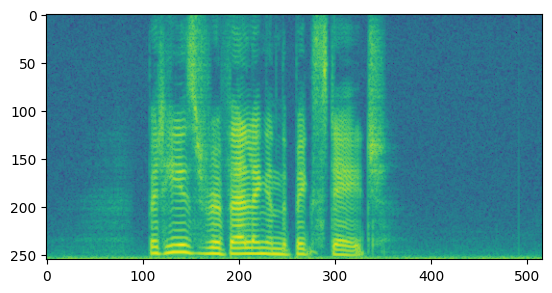

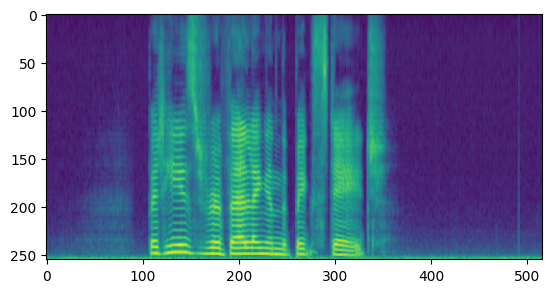

In [11]:

X_ = torchaudio.functional.spectrogram(
    waveform=torch.tensor(wavs[:160000*2], dtype=torch.float32),
    pad=0,
    window=torch.hann_window(512)/torch.sqrt(torch.tensor(1.5)),
    n_fft=512,
    hop_length=128,
    win_length=512,
    power=None,
    normalized=False)




X_ = X_[1:-1]
X_ = X_.t().to(device)

mu, sigma = encoder(X_)
_, Xhat = decoder(mu)
# plt.imshow(torch.log(torch.abs(Xhat)).cpu().detach().numpy().T[::-1])
plt.imshow(torch.log(torch.abs(X_)).cpu().detach().numpy().T[::-1][:,:129*4])
plt.show()
plt.imshow(torch.log(torch.abs(Xhat)).cpu().detach().numpy().T[::-1][:,:129*4])
plt.show()

In [59]:
from torch.nn import ZeroPad2d
import torch_specinv
zp = ZeroPad2d((1,1,0,0))
from tqdm import tqdm
import soundfile

fftsize = 512
window = (torch.hann_window(512, periodic=True)/torch.sqrt(torch.tensor(1.5))).to('cuda:0',dtype=torch.float)
sample_rate = 16000
signal_recons = torch_specinv.methods.ADMM(zp((Xhat)).T.detach(),
                                hop_length=fftsize//4,
                                win_length=fftsize,
                                # max_iter=50,
                                # alpha = 0.,
                                tol=1e-32,
                                max_iter=1000,
                                rho =0.8,
                                alpha = 0.99,
                                metric='sc',
                                eva_iter = 100,
                                verbose = True,
                                window=window).cpu().numpy()
soundfile.write(f"spec_inv_admm.wav", signal_recons, sample_rate)


100%|██████████| 1000/1000 [00:00<00:00, 1881.63it/s, SC=-20, loss=0.00137]


In [43]:
def transform_fn(X):

  out = torchaudio.functional.spectrogram(
      waveform=torch.tensor(X, dtype=torch.float32).cuda(),
      pad=0,
      window=torch.hann_window(512, periodic=True).cuda() / torch.sqrt(torch.tensor(1.5)).cuda(),
      n_fft=512,
      hop_length=128,
      win_length=512,
      power=2,
      normalized=False,
  )
  return out


In [ ]:
# @title Cannot remember how to use this API but this was the one that improved phase
# might need to go into the function and increase memory of LBFGS as well as
from torch.nn import ZeroPad2d
import torch_specinv
zp = ZeroPad2d((1,1,0,0))
from tqdm import tqdm
import soundfile

fftsize = 512
window = (torch.hann_window(512, periodic=True)/torch.sqrt(torch.tensor(1.5))).to('cuda:0',dtype=torch.float)
sample_rate = 16000
signal_recons = torch_specinv.methods.L_BFGS(zp((Xhat)).abs().T.detach().cuda(),
                                transform_fn=transform_fn,
                                init_x0 =torch.tensor(wavs[:160000*2], dtype=torch.float32).cuda(),
                                max_iter=100,
                                # alpha = 0.,
                                metric='snr',
                                eva_iter = 10,
                                verbose = True,
                                # window=window
                                             ).cpu().numpy()
soundfile.write(f"spec_inv_lbfgs.wav", signal_recons, sample_rate)
